# Data generation

In [20]:
import numpy as np
import torch
import scipy
import argparse
import sys
from arma import ode_system, solve_magi
from arma import matrix

days = 32  
discretization = 2
obs_per_day = 1
nobs = days * obs_per_day
MAGI_niter = 15001
N = 100000.
X = np.arange(0, days, 1. / (obs_per_day * discretization))
i0 = 50
e0 = 100
T = 2
parameter_value = [1.8, 0.1, 0.1, 0.2]
std = [1., 0.02, 0, 0.1]

tmp = np.linspace(0, 2 * T * np.pi, nobs)
true_re = parameter_value[0] - std[0] * np.cos(tmp)
true_ve = parameter_value[1]- std[1] * np.cos(tmp)
true_vi = parameter_value[2] 
true_pd = parameter_value[3] + std[3] * np.cos(tmp)
theta_true = np.vstack([true_re, true_ve, true_pd]).T

# data generation: all components in SEIRD model are generated according to experiment settings
def gen_data(true_re, true_ve, true_vi, true_pd, days, obs_per_day, state0=[N, 100, 50, 50], linspace=1000, noise=True):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    freq = 1. / discretization
    nFull = days * obs_per_day
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 4))
    state_ls[0][0] = np.log(state0[0])
    state_ls[0][1] = np.log(state0[1])
    state_ls[0][2] = np.log(state0[2])
    state_ls[0][3] = np.log(state0[3])

    for i in range(1, linspace * nFull):
        index = int(i / linspace)
        state_ls[i][0] = state_ls[i - 1][0] - step_size * true_re[index] * np.exp(state_ls[i - 1][2]) / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * true_re[index] * np.exp(state_ls[i - 1][0] + state_ls[i - 1][
            2] - state_ls[i - 1][1]) / N - step_size * true_ve[index]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * np.exp(
            state_ls[i - 1][1] - state_ls[i - 1][2]) * true_ve[index] - step_size * true_vi
        state_ls[i][3] = state_ls[i - 1][3] + step_size * np.exp(state_ls[i - 1][2] - state_ls[i - 1][3]) * true_pd[
            index] * true_vi
    states = state_ls[::linspace]
    # add noise
    if noise == True:
        states += np.random.normal(0, 0.01, size=states.shape)
    return states

true_x = gen_data(true_re, true_ve, true_vi, true_pd, days=days, obs_per_day=obs_per_day, noise=False)
true_x_torch = torch.tensor(true_x)

In [2]:
obs_per_day=1
discretization=2
theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, 1., 1., 1.])
MAGI_niter=15001
param_names = ['re', 've', 'vi', 'pd']
is_time_varying=[True, True, False, True]
pointwise_niter=150000
kernel_niter=60000
TVMAGI_niter=150000
phi1_lb_ls=np.array([0.1, 0.1, 0.1])
phi2_lb_ls=np.array([0.1, 0.1, 0.1])
use_trajectory='inferred'
learning_rate=np.array([1e-5, 1e-3, 1e-4])

# First step

In [3]:
# Derivatves of X according to the ODE structure
def fOde(theta, x):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[0] * np.exp(logI) / N  # (1)
    logEdt = theta[0] * np.exp(logS + logI - logE) / N - theta[1]  # (2)
    logIdt = np.exp(logE - logI) * theta[1] - theta[2]  # (3)
    logDdt = np.exp(logI - logD) * theta[3] * theta[2]  # (4)
    return np.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


# Derivatives of X
def fOdeDx(theta, x):
    """
    returns derivation of x given theta
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    resultDx = np.zeros(shape=[np.shape(x)[0], np.shape(x)[1], np.shape(x)[1]])
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程关于第i个状态求导
    # (1) / dI
    resultDx[:, 2, 0] = -theta[0] * np.exp(logI) / N
    # (1) / dS, (1) /dE, (1) / dD = 0
    # (2) / dS
    resultDx[:, 0, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dE
    resultDx[:, 1, 1] = -theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dI
    resultDx[:, 2, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dD = 0
    # (3) / dS = 0
    # (3) / dE
    resultDx[:, 1, 2] = np.exp(logE - logI) * theta[1]
    # (3) / dI
    resultDx[:, 2, 2] = -np.exp(logE - logI) * theta[1]
    # (3) / dD = 0, (4) / dS, dE = 0
    # (4) / dI
    resultDx[:, 2, 3] = np.exp(logI - logD) * theta[3] * theta[2]
    # (4) / dD
    resultDx[:, 3, 3] = -np.exp(logI - logD) * theta[3] * theta[2]
    return resultDx


def fOdeDtheta(theta, x):
    """
    returns derivation of theta given x
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    global N
    resultDtheta = np.zeros(shape=[np.shape(x)[0], np.shape(theta)[0], np.shape(x)[1]])
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程对theta_i求导
    # (1) / dRe
    resultDtheta[:, 0, 0] = -np.exp(logI) / N
    # (2) / d theta[0]
    resultDtheta[:, 0, 1] = np.exp(logS + logI - logE) / N
    # (2) / theta[1]
    resultDtheta[:, 1, 1] = -1.
    # (3) / dtheta[1]
    resultDtheta[:, 1, 2] = np.exp(logE - logI)
    # (3) / dtheta[2]
    resultDtheta[:, 2, 2] = -1.
    # (4) / theta[2]
    resultDtheta[:, 2, 3] = np.exp(logI - logD) * theta[3] 
    # (4) / theta[3]
    resultDtheta[:, 3, 3] = np.exp(logI - logD) * theta[2]
    return resultDtheta

nobs, p_dim = yobs.shape[0], yobs.shape[1]
days = nobs / obs_per_day
n_points = nobs * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
# First stage: use MAGI package to optimize theta as constant
result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=MAGI_niter,
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(MAGI_niter * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
        each_pycov = dict(
            Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
            Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
            mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
        )
        CovAllDimensionsPyList.append(each_pycov)

In [4]:
inferred_theta

array([1.85929337, 0.1033251 , 0.09881919, 0.19281501])

# Second step

In [5]:
def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[:, 0] * torch.exp(logI) / N  # (1)
    logEdt = theta[:, 0] * torch.exp(logS + logI - logE) / N - theta[:, 1]  # (2)
    logIdt = torch.exp(logE - logI) * theta[:, 1] - constant_param_ls[0]  # (3)
    logDdt = torch.exp(logI - logD) * theta[:, 2] * constant_param_ls[0]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature,
                                 obs_per_day):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)


def MaternKernel(d, phi_1, phi_2):
    """
    construct a kernel given time points and hyper parameters
    """
    a = torch.square(phi_1) * (
            1. + np.sqrt(5) * d / phi_2 + 5. * torch.square(d) / (3. * torch.square(phi_2))) * torch.exp(
        -np.sqrt(5) * d / phi_2)
    return a.double()


def kernelllik(phi_1, phi_2, sigma, y, d_matrix, phi1_lb=0.1, phi2_lb=10.):
    """
    optimize the kernel hyperparameters by maximizing marginal likelihood
    """
    phi_1_bounded = torch.clamp(phi_1, min=phi1_lb)
    phi_2_bounded = torch.clamp(phi_2, min=phi2_lb)
    K = MaternKernel(d_matrix, phi_1, phi_2)
    K += torch.square(sigma) * torch.eye(y.shape[0]).double()
    return -y.shape[0] * np.log(np.sqrt(2 * np.pi)) - 0.5 * y @ torch.inverse(K) @ y - 0.5 * torch.logdet(
        K) - 1e8 * torch.square(phi_1 - phi_1_bounded) - 1e6 * torch.square(phi_2 - phi_2_bounded)

# Second stage, pointwise estimation of theta
TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1

if use_trajectory == 'observation':
    pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
elif use_trajectory == 'inferred':
    pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
else:
    raise ValueError
tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == 0:
        param_name = param_names[thetaEachDim]
        locals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
        time_constant_param_ls.append(eval(param_name))

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=learning_rate[0])  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=100000, gamma=0.2)
for epoch in range(300000):
    pointwise_optimizer.zero_grad()
    # compute loss function
    llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                        TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                        priorTemperature, obs_per_day)
    loss = -llik
    if epoch % 100 == 0:
        print(epoch, loss.item())
    loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()

0 -83.73301365883506


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


100 -128.52682933853055
200 -131.5474157860835
300 -131.82141976538264
400 -132.03514219786197
500 -132.23942566890804
600 -132.43860388701248
700 -132.63413094918891
800 -132.82710470164582
900 -133.01850729700718
1000 -133.2091978113648
1100 -133.39991142692512
1200 -133.5912607692013
1300 -133.78376649039134
1400 -133.9778730145482
1500 -134.17396636004918
1600 -134.37239292442598
1700 -134.5734671383174
1800 -134.7774597616692
1900 -134.9846439583568
2000 -135.19526096639612
2100 -135.40953077178466
2200 -135.62764039902078
2300 -135.84977185351323
2400 -136.07609167746634
2500 -136.30673062398384
2600 -136.54181676160553
2700 -136.78146016960406
2800 -137.02574785752898
2900 -137.27476277523058
3000 -137.52856739523074
3100 -137.78721468586866
3200 -138.05074536604096
3300 -138.31919181766966
3400 -138.59256313308964
3500 -138.8708817864679
3600 -139.1541409420042
3700 -139.4423349006594
3800 -139.73543210411992
3900 -140.0334078507447
4000 -140.33621982927852
4100 -140.6438158291

32500 -298.25879546259387
32600 -299.58500481098264
32700 -300.93944063341235
32800 -302.32450236338724
32900 -303.743013485496
33000 -305.1983220959097
33100 -306.69444473299484
33200 -308.2362833431627
33300 -309.829875564833
33400 -311.48280009654314
33500 -313.2047530318358
33600 -315.00844661845025
33700 -316.91082886777826
33800 -318.9354173245317
33900 -321.11622388121185
34000 -323.5040064418421
34100 -326.1790961552919
34200 -329.2754989301173
34300 -333.0332260686166
34400 -337.9296532784746
34500 -345.1450240687305
34600 -359.94269365103696
34700 -366.3989893865051
34800 -373.90018981174944
34900 -374.3046871014545
35000 -372.45616626643675
35100 -376.1035553083008
35200 -372.87771826667813
35300 -372.1315632860704
35400 -373.3221943783482
35500 -374.533699729046
35600 -375.78668336537663
35700 -377.1007482284033
35800 -378.49763567570034
35900 -380.00156644216895
36000 -381.6345251096865
36100 -383.4228523856961
36200 -382.77337970875817
36300 -384.5761478156445
36400 -384.

65000 -533.6922534715334
65100 -536.4346373838329
65200 -539.194853591043
65300 -538.5325885520676
65400 -541.5074937551144
65500 -539.3399067997935
65600 -539.0370245738853
65700 -542.2704275506063
65800 -542.8146646391415
65900 -540.5193758047815
66000 -543.9528995699189
66100 -537.1449835349968
66200 -540.2238551133009
66300 -538.3830421565324
66400 -539.1100776006509
66500 -536.3306529271138
66600 -539.6474659187527
66700 -542.9722856261278
66800 -546.6959757608929
66900 -540.2338349181532
67000 -538.9057396717631
67100 -541.5462959179789
67200 -535.1152918089232
67300 -535.8323008387824
67400 -537.642132725078
67500 -539.4086412287827
67600 -541.2497833683141
67700 -543.2279558429284
67800 -545.3891783002681
67900 -541.1845594739256
68000 -543.3216447129621
68100 -545.3726109912993
68200 -547.5882336195987
68300 -547.9527699305864
68400 -549.9036797941641
68500 -548.6749301549717
68600 -551.1849935726945
68700 -554.0574379439207
68800 -550.9682415002662
68900 -553.9182834849227
69

97900 -656.8639454282346
98000 -656.9199640492141
98100 -658.7180242366535
98200 -653.3753312221404
98300 -655.5305220616053
98400 -657.72256413735
98500 -660.0624532645232
98600 -662.6351371323183
98700 -664.5472447430323
98800 -657.3761060199644
98900 -658.8357344879166
99000 -660.4776879689041
99100 -661.3233032390453
99200 -662.2248887243906
99300 -664.5775479859451
99400 -659.2768020661722
99500 -662.3209508385294
99600 -659.1976997018471
99700 -662.4010720206728
99800 -654.9284983730219
99900 -657.437035867879
100000 -659.919715722746
100100 -660.4430201048232
100200 -660.2467724074703
100300 -660.7999581017918
100400 -660.9528342266688
100500 -661.2410492754414
100600 -661.7239996759633
100700 -661.6089316835028
100800 -662.0094274662234
100900 -662.3430685098527
101000 -662.1441533191288
101100 -662.8943532610018
101200 -662.5022964299355
101300 -663.2936573091514
101400 -664.1298615835836
101500 -662.8434031916511
101600 -663.6453511637293
101700 -664.424228938382
101800 -665.

129700 -668.3821001541693
129800 -669.2887901411968
129900 -669.0947932254182
130000 -668.6716388928123
130100 -669.3777276202667
130200 -668.9004790771089
130300 -669.7149006309496
130400 -670.4218413251951
130500 -667.6115042744339
130600 -668.6821494226198
130700 -669.3364203450333
130800 -670.0138406459606
130900 -670.0697342944192
131000 -670.808318519034
131100 -669.3312041104197
131200 -670.0686229765237
131300 -670.8680571890518
131400 -668.7680273599815
131500 -668.905042462773
131600 -669.4930210891612
131700 -669.1981062696028
131800 -669.9829033119952
131900 -670.7775199757772
132000 -667.3211330282448
132100 -668.2266728112688
132200 -668.8138563202419
132300 -669.4092776255185
132400 -670.0469833880538
132500 -670.731875732675
132600 -669.6945316096932
132700 -669.9080928443174
132800 -670.5253489734145
132900 -668.1922404955002
133000 -669.3921992903382
133100 -668.9216226087228
133200 -669.6081462905769
133300 -670.3472245081858
133400 -668.949109518448
133500 -668.6105

161400 -669.1183225482453
161500 -669.835517240196
161600 -668.612800460773
161700 -668.8369037422091
161800 -668.5197098181648
161900 -669.1519636169145
162000 -667.790828800614
162100 -668.6774160684901
162200 -669.2448382431467
162300 -669.8396817809225
162400 -670.4785603225323
162500 -669.4690046447877
162600 -669.6139194637283
162700 -670.197220828331
162800 -670.3452408037754
162900 -669.1140130629555
163000 -669.4133937245974
163100 -670.037586960628
163200 -670.3344245006609
163300 -670.7697325607155
163400 -669.4712497212919
163500 -669.3394742858384
163600 -670.0655079542576
163700 -670.8583553627809
163800 -668.2125600412794
163900 -669.0199223743854
164000 -669.7288462725587
164100 -667.788309528281
164200 -668.5705997309932
164300 -669.1757807238735
164400 -669.084269456867
164500 -669.6246432208453
164600 -669.242429249032
164700 -669.824187616092
164800 -670.4508930665439
164900 -670.0885424906202
165000 -670.7641902761778
165100 -668.9720486884141
165200 -669.316525478

193100 -669.479286241267
193200 -666.3852764682939
193300 -669.9532104767977
193400 -670.7068219757532
193500 -669.3871857978316
193600 -670.1568125605107
193700 -670.2408948076543
193800 -668.7604598269169
193900 -669.5104804448624
194000 -668.9533232061676
194100 -669.6285654088792
194200 -670.3551718111217
194300 -670.0459139550242
194400 -668.67769752265
194500 -668.4705389942535
194600 -669.2730375920847
194700 -670.0029257216818
194800 -669.3928780922017
194900 -670.1663781148942
195000 -669.2437264363334
195100 -669.2487166290394
195200 -670.0109378051392
195300 -669.6274842534522
195400 -670.4398805380894
195500 -668.0617133653499
195600 -668.6939679396825
195700 -669.4173672958447
195800 -669.3715681306455
195900 -669.6086718114149
196000 -670.3513849510448
196100 -669.0181430521735
196200 -668.9565468391262
196300 -669.6786877553875
196400 -669.0912041570318
196500 -669.795884459658
196600 -670.5489966526208
196700 -667.6800650389213
196800 -668.3226668682543
196900 -668.9602

224800 -670.9035670867064
224900 -670.7972095113639
225000 -670.8076049632582
225100 -670.7145596265161
225200 -670.8942302343548
225300 -670.9303926620316
225400 -670.6026233209333
225500 -670.8079470127046
225600 -670.7430712046422
225700 -670.9671150372841
225800 -670.4981790475811
225900 -670.7067558008283
226000 -670.9280798053729
226100 -670.3704080319053
226200 -670.6401027032399
226300 -670.6445055310602
226400 -670.7602722093745
226500 -669.819101567689
226600 -670.8373222696051
226700 -670.8819304634382
226800 -670.7662915715047
226900 -670.962393024332
227000 -670.8840507534982
227100 -670.5782361986749
227200 -670.7307868184367
227300 -670.547600769409
227400 -670.697545230089
227500 -670.8564780017335
227600 -671.0244213587724
227700 -670.6421611595579
227800 -670.7953485486793
227900 -670.8309917177254
228000 -670.8469213595372
228100 -671.0714587038693
228200 -670.6695471631471
228300 -670.8432837316661
228400 -670.8400560524406
228500 -670.5232905321295
228600 -670.4954

256500 -670.8087427205303
256600 -670.9753876300284
256700 -670.6625712408706
256800 -670.8204642798979
256900 -670.9971702516439
257000 -670.6777282414162
257100 -670.85029383556
257200 -670.890224009671
257300 -670.6114026305639
257400 -670.6885601309425
257500 -670.5923974923155
257600 -670.7628703512078
257700 -670.9451715044681
257800 -670.8362954576753
257900 -670.789142736056
258000 -670.6403604896053
258100 -670.8379067907081
258200 -670.8657178697506
258300 -671.0619498543911
258400 -670.7913112249666
258500 -670.8423439770444
258600 -670.8616499600903
258700 -670.5242851566592
258800 -670.6258675017957
258900 -670.8020875443942
259000 -670.7320587860946
259100 -670.9174767822053
259200 -670.7616403930472
259300 -670.8006558992824
259400 -670.9763857267608
259500 -670.6693805326788
259600 -670.8541679657358
259700 -670.7726038811135
259800 -670.9619600131114
259900 -670.7107362500213
260000 -670.596856493914
260100 -670.7575175540525
260200 -670.9278076018182
260300 -670.78269

288200 -670.7672632359328
288300 -670.7015390551421
288400 -670.8966804550603
288500 -670.9404082709652
288600 -670.4771405389283
288700 -670.64728715463
288800 -670.8305500050444
288900 -670.7074281513699
289000 -670.8891690769609
289100 -671.0777894258924
289200 -670.6322383840596
289300 -670.8128571522201
289400 -670.3365537608775
289500 -670.7707251248663
289600 -670.6536836734318
289700 -670.8267468522434
289800 -671.0098034385774
289900 -670.6559283614027
290000 -670.8248189387327
290100 -671.0178661999311
290200 -670.6461167736239
290300 -670.82982846838
290400 -671.0263843605377
290500 -670.7102613408808
290600 -670.9093457594452
290700 -670.8667826620347
290800 -670.8081759586315
290900 -670.7691105328076
291000 -670.6680519842827
291100 -670.8507472316004
291200 -670.7589976996258
291300 -670.6936393995106
291400 -670.9029425914649
291500 -670.5719465986423
291600 -670.7225882879405
291700 -670.9327302796606
291800 -670.7485734300244
291900 -670.500350959856
292000 -670.66780

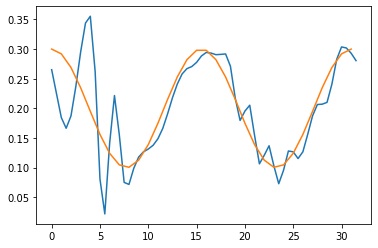

In [6]:
import matplotlib.pyplot as plt

pointwise_theta = pointwise_theta_torch.detach().numpy()
plt.plot(np.arange(0, 32, 0.5), pointwise_theta[:, 2])
plt.plot(true_pd)

In [7]:
def MaternKernel(d, phi_1, phi_2):
    """
    construct a kernel given time points and hyper parameters
    """
    a = torch.square(phi_1) * (
            1. + np.sqrt(5) * d / phi_2 + 5. * torch.square(d) / (3. * torch.square(phi_2))) * torch.exp(
        -np.sqrt(5) * d / phi_2)
    return a.double()


def kernelllik(phi_1, phi_2, sigma, y, d_matrix, phi1_lb=0.1, phi2_lb=10., sigma_lb = 0.03):
    """
    optimize the kernel hyperparameters by maximizing marginal likelihood
    """
    phi_1_bounded = torch.clamp(phi_1, min=phi1_lb)
    phi_2_bounded = torch.clamp(phi_2, min=phi2_lb)
    sigma_bounded = torch.clamp(sigma, min=sigma_lb)
    K = MaternKernel(d_matrix, phi_1, phi_2)
    K += torch.square(sigma) * torch.eye(y.shape[0]).double()
    return -y.shape[0] * np.log(np.sqrt(2 * np.pi)) - 0.5 * y @ torch.inverse(K) @ y - 0.5 * torch.logdet(K) - 1e8 * torch.square(phi_1 - phi_1_bounded) - 1e6 * torch.square(phi_2 - phi_2_bounded) - 1e6 * torch.square(sigma - sigma_bounded)


pointwise_theta = pointwise_theta_torch.detach().numpy()
theta_true_torch = torch.tensor(theta_true)
hyperparamList = []
phi1_lb_ls=np.array([0.1, 0.1, 0.1])
phi2_lb_ls=np.array([5., 5., 5.])
kernel_niter=20000
# optimize the hyperparameters of kernels
for thetaEachDimension in range(pointwise_theta.shape[1]):
    phi_1 = torch.tensor(1., requires_grad=True, dtype=torch.double)
    phi_2 = torch.tensor(15.0, requires_grad=True, dtype=torch.double)
    sigma = torch.tensor(0.05, requires_grad=True, dtype=torch.double)
    kernel_optimizer = torch.optim.Adam([phi_1, phi_2, sigma], lr=learning_rate[1])
    for epoch in range(kernel_niter):
        kernel_optimizer.zero_grad()
        loss = -kernelllik(phi_1, 
                           phi_2, 
                           sigma, 
                           pointwise_theta_torch[:, thetaEachDimension] - torch.mean(pointwise_theta_torch[:, thetaEachDimension]), 
                           d_matrix, 
                           phi1_lb_ls[thetaEachDimension], 
                           phi2_lb_ls[thetaEachDimension])
        loss.backward()
        kernel_optimizer.step()
        if epoch % 100 == 0:
            print(epoch, loss.item())
    print(phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item())
    hyperparamList.append([phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item()])

KthetaList = []
KinvthetaList = []
for thetaEachDimension in range(pointwise_theta.shape[1]):
    ker = MaternKernel(d_matrix, torch.tensor(hyperparamList[thetaEachDimension][0]), torch.tensor(hyperparamList[thetaEachDimension][1]))
    KthetaList.append(ker)
    KinvthetaList.append(torch.inverse(ker))

0 41.30442260801712
100 19.42426569695533
200 4.861722586423241
300 -6.001195084944641
400 -14.39228258630834
500 -21.06985233045401
600 -26.51452953008402
700 -31.04316780926058
800 -34.87249243068277
900 -38.155584133196015
1000 -41.003601841221325
1100 -43.49920896031429
1200 -45.70515919769596
1300 -47.66995606684982
1400 -49.431685095253954
1500 -51.02067135710179
1600 -52.461361966529154
1700 -53.77368514861088
1800 -54.97404833402102
1900 -56.076082560320145
2000 -57.09120549859024
2100 -58.02905277738637
2200 -58.89781230190266
2300 -59.70448618882399
2400 -60.455098036673576
2500 -61.15485845280779
2600 -61.808298373914994
2700 -62.419377299723195
2800 -62.991571806665206
2900 -63.527948430570206
3000 -64.03122405924671
3100 -64.50381626864622
3200 -64.94788550353233
3300 -65.36537059879319
3400 -65.75801882740063
3500 -66.12741142063277
3600 -66.47498532180114
3700 -66.80205178790018
3800 -67.10981233941884
3900 -67.39937246858099
4000 -67.67175344406853
4100 -67.927902491768

13100 -151.23012388864387
13200 -151.15384859272615
13300 -150.95613744974
13400 -151.0666342962063
13500 -151.2243042039723
13600 -151.1006846431335
13700 -151.2631733782072
13800 -150.88390824071985
13900 -151.0058365590089
14000 -151.1479371913253
14100 -151.27604724156646
14200 -151.05834229879596
14300 -151.20290537243267
14400 -151.18625803715685
14500 -151.25013778013255
14600 -151.08998429498735
14700 -151.25060532506282
14800 -150.94506797076616
14900 -151.03766583917704
15000 -151.19441877656368
15100 -150.7785111594063
15200 -150.8909263145197
15300 -151.0142946928821
15400 -151.14269739881595
15500 -151.07129887197044
15600 -150.9654858346384
15700 -151.08903120744657
15800 -151.219302170991
15900 -151.12684039374065
16000 -151.27132982320762
16100 -151.03320921716943
16200 -151.17400734153722
16300 -150.9656524969743
16400 -151.08983983658973
16500 -151.24035490910344
16600 -150.8442755593572
16700 -150.87235489312604
16800 -150.99235804148043
16900 -151.1188380118691
1700

In [22]:
time_constant_param_ls
pointwise_theta_torch.shape

torch.Size([64, 3])

Text(0.5, 1.0, 'Adam Trace Plot (SEIR)')

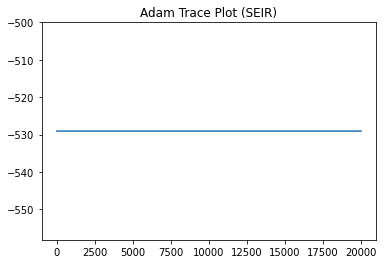

In [17]:
plt.plot(LossVal[-20000:])
plt.title('Adam Trace Plot (SEIR)')

# Third stage

In [8]:
def xthetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                         priorTemperature,
                         KinvthetaList):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    res2 = torch.zeros(1).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(
            (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]) @ KinvthetaList[thetaEachDim] @ (
                    theta[:, thetaEachDim] - inferred_theta[thetaEachDim]))
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

    return torch.sum(res) + torch.sum(res_theta)

TVMAGI_xlatent_torch = torch.tensor(pointwise_xlatent_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
TVMAGI_theta_torch = torch.tensor(pointwise_theta_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
TVMAGI_sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
TVMAGI_optimizer = torch.optim.Adam([TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch] + time_constant_param_ls, lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(TVMAGI_optimizer, step_size=10000, gamma=0.2)
LossVal = np.zeros(300000)
for epoch in range(300000):
    TVMAGI_optimizer.zero_grad()
    # compute loss function
    llik = xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch, time_constant_param_ls, TVMAGI_sigma_torch,
                                                TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                priorTemperature, KinvthetaList)
    loss = -llik
    if epoch % 100 == 0:
        print(epoch, loss.item())
    LossVal[epoch] = loss.item()
    loss.backward()
    TVMAGI_optimizer.step()
    lr_scheduler.step()

0 55311.32509668459
100 8641.744846338393
200 3678.455921318845
300 2326.0047607549022
400 1596.516574729399
500 1126.4221560154956
600 810.0020422331115
700 588.2040178183834
800 424.9563099486963
900 300.1704653654571
1000 194.57869228278673
1100 105.34430407981716
1200 24.30926346352402
1300 -54.4501430482465
1400 -134.81323121713712
1500 -226.64934144372614
1600 -304.00352899148345
1700 -360.01645325301917
1800 -387.4947869557616
1900 -406.74912881848826
2000 -420.57234446186794
2100 -433.68798493603197
2200 -443.3970376782073
2300 -451.3716505736968
2400 -458.15634743029113
2500 -463.89025224447244
2600 -469.2767556961226
2700 -474.11146391783495
2800 -476.3183353461232
2900 -482.39764498314986
3000 -486.0204033995651
3100 -489.52085879028016
3200 -492.67695506312083
3300 -495.8179174053654
3400 -498.6088420719219
3500 -475.04028727538696
3600 -503.59274571655993
3700 -505.78358992958914
3800 -507.7687273306593
3900 -509.59291003004455
4000 -511.1315371209587
4100 -512.71206557907

33300 -529.0757940868651
33400 -529.0758388136292
33500 -529.075884110004
33600 -529.0759279961715
33700 -529.0759119090501
33800 -529.0760124582888
33900 -529.0760540412807
34000 -529.0760873559085
34100 -529.0761294160367
34200 -529.0761668355415
34300 -529.0762002912023
34400 -529.0762354166699
34500 -529.0759237200307
34600 -529.0763003318879
34700 -529.0763317001193
34800 -529.0763514007336
34900 -529.0763902202783
35000 -529.0735702403796
35100 -529.0764451105402
35200 -529.0764713838386
35300 -529.0764953620057
35400 -529.0765206505455
35500 -529.0759300971529
35600 -529.076566769063
35700 -529.0765897413662
35800 -529.0766096120999
35900 -529.076631431011
36000 -529.0752562564378
36100 -529.0766707034485
36200 -529.076689514261
36300 -529.0766875790057
36400 -529.0767247307331
36500 -529.0740046726224
36600 -529.0767578164795
36700 -529.0767738882414
36800 -529.0767702361953
36900 -529.0768032991932
37000 -529.0768177176378
37100 -529.0768291857537
37200 -529.0768442070442
3730

66300 -529.0772299107496
66400 -529.0772299436036
66500 -529.0772299478651
66600 -529.0772299570057
66700 -529.0772299591528
66800 -529.0772299517071
66900 -529.0772299629949
67000 -529.077229967094
67100 -529.0772299655462
67200 -529.0772299698302
67300 -529.0772299722853
67400 -529.0772299514127
67500 -529.0772299792803
67600 -529.0772299836885
67700 -529.077229983645
67800 -529.077229955569
67900 -529.0772299889694
68000 -529.077229987508
68100 -529.0772299974765
68200 -529.0772298883502
68300 -529.077229997555
68400 -529.0772299982236
68500 -529.0772300045494
68600 -529.077230003671
68700 -529.0772300012324
68800 -529.0772300070373
68900 -529.0772300089063
69000 -529.0772300014627
69100 -529.0772300125842
69200 -529.0772300100405
69300 -529.0772300149789
69400 -529.0772300138736
69500 -529.0772300188491
69600 -529.0772300226434
69700 -529.0772300248153
69800 -529.0772300038003
69900 -529.0772300204849
70000 -529.0772300282301
70100 -529.0772300206984
70200 -529.0772300196445
70300 

99300 -529.0772300590774
99400 -529.0772300590527
99500 -529.0772300548488
99600 -529.07723005536
99700 -529.0772300498566
99800 -529.0772300581189
99900 -529.0772300528565
100000 -529.0772300630588
100100 -529.0772300522915
100200 -529.0772300643528
100300 -529.077230053276
100400 -529.0772300591098
100500 -529.0772300564294
100600 -529.0772300560017
100700 -529.0772300558864
100800 -529.0772300559277
100900 -529.0772300605548
101000 -529.0772300517787
101100 -529.0772300539659
101200 -529.0772300559559
101300 -529.0772300568951
101400 -529.0772300552532
101500 -529.0772300570077
101600 -529.0772300589293
101700 -529.0772300540807
101800 -529.0772300552545
101900 -529.0772300572181
102000 -529.0772300592168
102100 -529.0772300571444
102200 -529.0772300523406
102300 -529.0772300576284
102400 -529.077230057315
102500 -529.0772300582532
102600 -529.0772300619841
102700 -529.0772300561961
102800 -529.077230055606
102900 -529.0772300571286
103000 -529.0772300573425
103100 -529.077230055960

131100 -529.077230052705
131200 -529.0772300558449
131300 -529.0772300615351
131400 -529.0772300586337
131500 -529.0772300570732
131600 -529.0772300588706
131700 -529.0772300497985
131800 -529.0772300599099
131900 -529.0772300575833
132000 -529.0772300578358
132100 -529.0772300573194
132200 -529.0772300597837
132300 -529.0772300575924
132400 -529.0772300538719
132500 -529.0772300588081
132600 -529.0772300530264
132700 -529.0772300559122
132800 -529.0772300614921
132900 -529.0772300534953
133000 -529.0772300585995
133100 -529.0772300576599
133200 -529.0772300594543
133300 -529.0772300536214
133400 -529.0772300596011
133500 -529.0772300583183
133600 -529.0772300571059
133700 -529.077230054168
133800 -529.0772300576973
133900 -529.0772300557022
134000 -529.0772300542704
134100 -529.0772300574727
134200 -529.0772300618477
134300 -529.0772300582744
134400 -529.077230054961
134500 -529.0772300659323
134600 -529.0772300568772
134700 -529.0772300553468
134800 -529.0772300569861
134900 -529.077

162800 -529.0772300555527
162900 -529.0772300553637
163000 -529.0772300550612
163100 -529.0772300554377
163200 -529.0772300555809
163300 -529.0772300558014
163400 -529.0772300553651
163500 -529.0772300554268
163600 -529.0772300555686
163700 -529.0772300554029
163800 -529.0772300550029
163900 -529.0772300549964
164000 -529.07723005548
164100 -529.0772300556242
164200 -529.0772300556357
164300 -529.0772300554604
164400 -529.0772300553726
164500 -529.0772300560009
164600 -529.0772300560507
164700 -529.077230055677
164800 -529.0772300557662
164900 -529.0772300551656
165000 -529.0772300555549
165100 -529.0772300555236
165200 -529.0772300555439
165300 -529.0772300553442
165400 -529.0772300550761
165500 -529.0772300559363
165600 -529.077230055379
165700 -529.0772300551382
165800 -529.0772300554988
165900 -529.0772300552172
166000 -529.0772300553476
166100 -529.0772300554866
166200 -529.0772300549064
166300 -529.0772300553391
166400 -529.0772300556008
166500 -529.0772300554898
166600 -529.0772

194500 -529.0772300554834
194600 -529.0772300554834
194700 -529.0772300554834
194800 -529.0772300554834
194900 -529.0772300554834
195000 -529.0772300554834
195100 -529.0772300554834
195200 -529.0772300554834
195300 -529.0772300554834
195400 -529.0772300554834
195500 -529.0772300554834
195600 -529.0772300554834
195700 -529.0772300554834
195800 -529.0772300554834
195900 -529.0772300554834
196000 -529.0772300554834
196100 -529.0772300554834
196200 -529.0772300554834
196300 -529.0772300554834
196400 -529.0772300554834
196500 -529.0772300554834
196600 -529.0772300554834
196700 -529.0772300554834
196800 -529.0772300554834
196900 -529.0772300554834
197000 -529.0772300554834
197100 -529.0772300554834
197200 -529.0772300554834
197300 -529.0772300554834
197400 -529.0772300554834
197500 -529.0772300554834
197600 -529.0772300554834
197700 -529.0772300554834
197800 -529.0772300554834
197900 -529.0772300554834
198000 -529.0772300554834
198100 -529.0772300554834
198200 -529.0772300554834
198300 -529.

226100 -529.0772300554834
226200 -529.0772300554834
226300 -529.0772300554834
226400 -529.0772300554834
226500 -529.0772300554834
226600 -529.0772300554834
226700 -529.0772300554834
226800 -529.0772300554834
226900 -529.0772300554834
227000 -529.0772300554834
227100 -529.0772300554834
227200 -529.0772300554834
227300 -529.0772300554834
227400 -529.0772300554834
227500 -529.0772300554834
227600 -529.0772300554834
227700 -529.0772300554834
227800 -529.0772300554834
227900 -529.0772300554834
228000 -529.0772300554834
228100 -529.0772300554834
228200 -529.0772300554834
228300 -529.0772300554834
228400 -529.0772300554834
228500 -529.0772300554834
228600 -529.0772300554834
228700 -529.0772300554834
228800 -529.0772300554834
228900 -529.0772300554834
229000 -529.0772300554834
229100 -529.0772300554834
229200 -529.0772300554834
229300 -529.0772300554834
229400 -529.0772300554834
229500 -529.0772300554834
229600 -529.0772300554834
229700 -529.0772300554834
229800 -529.0772300554834
229900 -529.

257700 -529.0772300554834
257800 -529.0772300554834
257900 -529.0772300554834
258000 -529.0772300554834
258100 -529.0772300554834
258200 -529.0772300554834
258300 -529.0772300554834
258400 -529.0772300554834
258500 -529.0772300554834
258600 -529.0772300554834
258700 -529.0772300554834
258800 -529.0772300554834
258900 -529.0772300554834
259000 -529.0772300554834
259100 -529.0772300554834
259200 -529.0772300554834
259300 -529.0772300554834
259400 -529.0772300554834
259500 -529.0772300554834
259600 -529.0772300554834
259700 -529.0772300554834
259800 -529.0772300554834
259900 -529.0772300554834
260000 -529.0772300554834
260100 -529.0772300554834
260200 -529.0772300554834
260300 -529.0772300554834
260400 -529.0772300554834
260500 -529.0772300554834
260600 -529.0772300554834
260700 -529.0772300554834
260800 -529.0772300554834
260900 -529.0772300554834
261000 -529.0772300554834
261100 -529.0772300554834
261200 -529.0772300554834
261300 -529.0772300554834
261400 -529.0772300554834
261500 -529.

289300 -529.0772300554834
289400 -529.0772300554834
289500 -529.0772300554834
289600 -529.0772300554834
289700 -529.0772300554834
289800 -529.0772300554834
289900 -529.0772300554834
290000 -529.0772300554834
290100 -529.0772300554834
290200 -529.0772300554834
290300 -529.0772300554834
290400 -529.0772300554834
290500 -529.0772300554834
290600 -529.0772300554834
290700 -529.0772300554834
290800 -529.0772300554834
290900 -529.0772300554834
291000 -529.0772300554834
291100 -529.0772300554834
291200 -529.0772300554834
291300 -529.0772300554834
291400 -529.0772300554834
291500 -529.0772300554834
291600 -529.0772300554834
291700 -529.0772300554834
291800 -529.0772300554834
291900 -529.0772300554834
292000 -529.0772300554834
292100 -529.0772300554834
292200 -529.0772300554834
292300 -529.0772300554834
292400 -529.0772300554834
292500 -529.0772300554834
292600 -529.0772300554834
292700 -529.0772300554834
292800 -529.0772300554834
292900 -529.0772300554834
293000 -529.0772300554834
293100 -529.

In [ ]:
import matplotlib.pyplot as plt

TVMAGI_theta = TVMAGI_theta_torch.detach().numpy()
plt.plot(np.arange(0, 32, 0.5), TVMAGI_theta[:, 2])
plt.plot(true_pd)

In [34]:
TVMAGI_theta_torch.grad

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0

# HMC

In [56]:
def vectorize(xlatent, theta, sigma, time_constant_param_ls):
    t1 = torch.reshape(xlatent.detach(), (-1,))
    t2 = torch.reshape(theta.detach(), (-1,))
    t3 = torch.reshape(sigma.detach(), (-1,))
    long_vec = torch.cat((t1, t2, t3))
    for i in range(len(time_constant_param_ls)):
        long_vec = torch.cat((long_vec, time_constant_param_ls[i].detach()))
    return long_vec

def get_dim(tensor_shape):
    if len(tensor_shape) == 0:
        return 1
    if len(tensor_shape) == 1:
        return tensor_shape[0]
    dim = 1
    for i in range(len(tensor_shape)):
        dim *= tensor_shape[i]
    return dim
    
def devectorize(long_tensor, xlatent_shape, theta_shape, sigma_shape, time_constant_param_dim):
    x_latent_dim = get_dim(xlatent_shape)
    theta_dim = get_dim(theta_shape)
    sigma_dim = get_dim(sigma_shape)
    time_constant_param_ls = []
    xlatent = torch.reshape(long_tensor[:x_latent_dim],xlatent_shape)
    theta = torch.reshape(long_tensor[x_latent_dim:x_latent_dim + theta_dim],theta_shape)
    sigma = torch.reshape(long_tensor[x_latent_dim + theta_dim:x_latent_dim + theta_dim + sigma_dim],sigma_shape)
    for each in range(x_latent_dim + theta_dim + sigma_dim, long_tensor.shape[0]):
        time_constant_param_ls.append(torch.tensor([long_tensor[each]]))
    return xlatent, theta, sigma, time_constant_param_ls


def NegLogLikelihood(xlatent, theta, time_constant_param_ls, sigma, 
                     inferred_theta = inferred_theta, 
                     ydata = ydata, 
                     CovAllDimensionsPyList = CovAllDimensionsPyList, 
                     fOdeTorch = fOdeTorch,
                     priorTemperature = priorTemperature, 
                     KinvthetaList = KinvthetaList):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(
            (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]) @ KinvthetaList[thetaEachDim] @ (
                    theta[:, thetaEachDim] - inferred_theta[thetaEachDim]))
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

    return -(torch.sum(res) + torch.sum(res_theta))

class HMC:
    def __init__(self, negllik, all_theta, xlatent_shape, theta_shape, sigma_shape, time_constant_param_ls, lsteps=50, epsilon=1e-6, n_samples=4000, upper_bound = None, lower_bound = None, burn_in_ratio = 0.5):
        self.all_theta = all_theta
        self.theta_shape = theta_shape
        self.xlatent_shape = xlatent_shape
        self.sigma_shape = sigma_shape
        self.constant_dim = len(time_constant_param_ls)
        self.lsteps = lsteps
        self.epsilon = epsilon * torch.ones(all_theta.shape)
        self.burn_in_ratio = burn_in_ratio
        self.n_samples = n_samples
        self.total_samples = int(n_samples / (1 - burn_in_ratio))
        self.NegLogLikelihood = negllik
        self.ub = upper_bound
        if upper_bound is not None:
            if upper_bound.shape[0] != all_theta.shape[0]:
                raise ValueError
        self.lb = lower_bound
        if lower_bound is not None:
            if lower_bound.shape[0] != all_theta.shape[0]:
                raise ValueError
    
    def NegLogLikelihood_vec(self, all_theta):
        xlatent_0, theta_0, sigma_0, constant_param_ls_0 = devectorize(all_theta, self.xlatent_shape, self.theta_shape, self.sigma_shape, self.constant_dim)
        return NegLogLikelihood(xlatent_0, theta_0, constant_param_ls_0, sigma_0)
    
    def Nabla(self, theta_torch):
        theta_torch = theta_torch.detach()
        xlatent, theta, sigma, constant_param_ls = devectorize(theta_torch, self.xlatent_shape, self.theta_shape, self.sigma_shape, self.constant_dim)
        xlatent.requires_grad = True  
        theta.requires_grad = True
        sigma.requires_grad = True
        for each in constant_param_ls:
            each.requires_grad = True                      
        llik = self.NegLogLikelihood(xlatent, theta, constant_param_ls, sigma)
        llik.backward()
        constant_param_deriv_ls = []
        for each in constant_param_ls:
            constant_param_deriv_ls.append(each.grad)
        v = vectorize(xlatent.grad, theta.grad, sigma.grad, constant_param_deriv_ls)
#         v = torch.clamp(v, min = -1e6)
#         v = torch.clamp(v, max = 1e6)
        return v
    def sample(self, all_theta, TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, KinvthetaList):
        def bounce(m, lb, ub):
            if lb is None and ub is None:
                return m
            if lb is None:
                max_tensor = torch.clamp(m - ub, min=0)
                return m - 2 * max_tensor
            if ub is None:
                min_tensor = torch.clamp(lb - m, min=0)
                return m + 2 * min_tensor
            if torch.sum(lb < ub) < m.shape[0]:
                raise ValueError
            if torch.sum(m >= lb) == m.shape[0] and torch.sum(m <= ub) == m.shape[0]:
                return m
            if torch.sum(m >= lb) < m.shape[0]:
                min_tensor = torch.clamp(lb - m, min=0)
                return bounce(m + 2 * min_tensor, lb, ub)
            if torch.sum(m <= ub) < m.shape[0]:
                max_tensor = torch.clamp(m - ub, min=0)
                return bounce(m - 2 * max_tensor, lb, ub)

        trace_val = np.zeros(self.total_samples)
        samples = np.zeros((self.total_samples, self.all_theta.shape[0]))
        random_ls = np.random.uniform(0, 1, self.total_samples)
        acceptance_ls = np.zeros(self.total_samples)
        nan_ls = np.zeros(self.total_samples)
        cur_theta = self.all_theta.clone().detach()
        for EachIter in range(self.total_samples): ############
            if EachIter % 100 == 0 and EachIter > 100:
                print(EachIter)
                print(cur_nllik)
            cur_nllik_1 = self.NegLogLikelihood_vec(cur_theta).detach()
            rstep = torch.rand(self.epsilon.shape) * self.epsilon + self.epsilon
            p = torch.normal(mean=0., std=torch.ones(self.all_theta.shape))
            cur_p = p.clone()
            theta = cur_theta.clone()         
            p = p - rstep * self.Nabla(theta).clone() / 2
            for i in range(self.lsteps):
                theta = theta + rstep * p
                nabla_torch = self.Nabla(theta).clone()
                p = p - rstep * nabla_torch
                theta = bounce(theta, self.lb, self.ub)
            
            p = p - rstep * self.Nabla(theta).clone() / 2
            
            new_nllik = self.NegLogLikelihood_vec(theta)
            new_p = 0.5 * torch.sum(torch.square(p))
            new_H = new_nllik + new_p
            cur_nllik = self.NegLogLikelihood_vec(cur_theta).detach()
            cur_H = cur_nllik + 0.5 * torch.sum(torch.square(cur_p))
            
            if torch.isnan(theta[0]) or torch.isnan(new_H):
                samples[EachIter] = cur_theta.clone()
                nan_ls[EachIter] = 1
                self.epsilon *= 0.9
            else:
                # accept
                tmp = float(torch.exp(cur_H - new_H))
                if  tmp > random_ls[EachIter]:
                    samples[EachIter] = theta.clone()
                    cur_theta = theta.clone()
                    acceptance_ls[EachIter] = 1
                # reject
                else:
                    samples[EachIter] = cur_theta.clone()
                    
            trace_val[EachIter] = self.NegLogLikelihood_vec(cur_theta).item()        

            if EachIter > 200 and EachIter < self.total_samples - self.n_samples:
                if np.sum(acceptance_ls[EachIter - 100 : EachIter]) < 60:
                    # decrease epsilon
                    self.epsilon *= 0.995
                if np.sum(acceptance_ls[EachIter - 100 : EachIter]) > 80:
                    # increase epsilon
                    self.epsilon *= 1.005
            if EachIter % 100 == 0 and EachIter > 100 and EachIter < self.total_samples - self.n_samples:
                print(EachIter)
                print(cur_nllik)
                print('acceptance rate: ', np.sum(acceptance_ls[EachIter - 100 : EachIter]) / 100)
                standard_deviation = torch.tensor(np.std(samples[EachIter - 100:EachIter, :], axis = 0))
                if torch.mean(standard_deviation) > 1e-6:
                    self.epsilon = 0.05 * standard_deviation * torch.mean(self.epsilon) / torch.mean(standard_deviation) + 0.95 * self.epsilon
        return samples, acceptance_ls, trace_val, nan_ls # [self.total_samples-self.n_samples:, :]

# all_theta = vectorize(TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch, time_constant_param_ls)
all_theta_true = vectorize(true_x_torch, theta_true_torch, TVMAGI_sigma_torch, time_constant_param_ls)
# all_theta_pointwise = vectorize(pointwise_xlatent_torch, pointwise_theta_torch, TVMAGI_sigma_torch, time_constant_param_ls)
sampler = HMC(NegLogLikelihood, all_theta_true, 
              pointwise_xlatent_torch.shape,
              pointwise_theta_torch.shape, 
              sigma_torch.shape,
              time_constant_param_ls,
             lower_bound = torch.zeros(all_theta_true.shape))
# sampler.Nabla(all_theta)
samples, b, c, d = sampler.sample(all_theta_true, TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, KinvthetaList)
# 
# print(sampler.NegLogLikelihood_vec(all_theta))
# sampler.sample(all_theta)
# 20 l step
# epsilon random start epsilon to 2 epsilon

200
tensor(2827.2785, dtype=torch.float64)
200
tensor(2817.2425, dtype=torch.float64)
acceptance rate:  0.76
300
tensor(2543.7110, dtype=torch.float64)
300
tensor(2542.4487, dtype=torch.float64)
acceptance rate:  0.74
400
tensor(2308.6695, dtype=torch.float64)
400
tensor(2306.9559, dtype=torch.float64)
acceptance rate:  0.66
500
tensor(2012.5194, dtype=torch.float64)
500
tensor(2012.0298, dtype=torch.float64)
acceptance rate:  0.75
600
tensor(1666.6573, dtype=torch.float64)
600
tensor(1661.5107, dtype=torch.float64)
acceptance rate:  0.82
700
tensor(1334.7972, dtype=torch.float64)
700
tensor(1334.8995, dtype=torch.float64)
acceptance rate:  0.74
800
tensor(1076.8747, dtype=torch.float64)
800
tensor(1068.6167, dtype=torch.float64)
acceptance rate:  0.69
900
tensor(915.8576, dtype=torch.float64)
900
tensor(917.4539, dtype=torch.float64)
acceptance rate:  0.69
1000
tensor(835.3833, dtype=torch.float64)
1000
tensor(835.3833, dtype=torch.float64)
acceptance rate:  0.69
1100
tensor(727.4682,

In [49]:
# all_theta = vectorize(TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch, time_constant_param_ls)
theta_true_torch
all_theta_true = vectorize(true_x_torch, theta_true_torch, TVMAGI_sigma_torch, time_constant_param_ls)
sampler.NegLogLikelihood_vec(all_theta_true)

tensor(10534.0461, dtype=torch.float64)

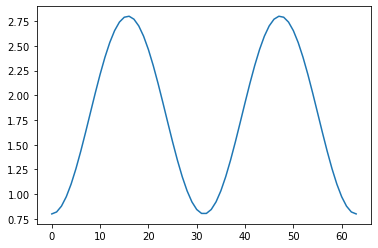

In [54]:
parameter_value = [1.8, 0.1, 0.1, 0.2]
std = [1., 0.02, 0, 0.1]

tmp2 = np.linspace(0, 2 * T * np.pi, 2 * nobs)
true_re2 = parameter_value[0] - std[0] * np.cos(tmp2)
true_ve2 = parameter_value[1]- std[1] * np.cos(tmp2)
true_vi2 = parameter_value[2] 
true_pd2 = parameter_value[3] + std[3] * np.cos(tmp2)
theta_true_Full = np.vstack([true_re2, true_ve2, true_pd2]).T
plt.plot(theta_true_Full[:, 0])
theta_true_torch = torch.tensor(theta_true_Full)

In [55]:
xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch, time_constant_param_ls, TVMAGI_sigma_torch,
                                                TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                priorTemperature, KinvthetaList)

xthetasigmallikTorch(true_x_torch, theta_true_torch, time_constant_param_ls, TVMAGI_sigma_torch,
                                                TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                priorTemperature, KinvthetaList)

tensor(-3549.7590, dtype=torch.float64, grad_fn=<AddBackward0>)

Text(0.5, 1.0, '$v^e$ (truth, Trained hyper)')

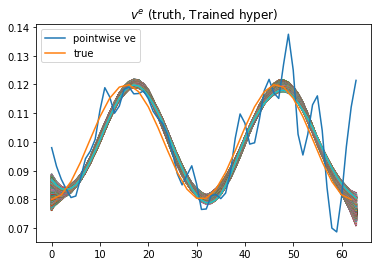

In [61]:
k = samples[4000:, 256:256+192]
val = np.zeros((64, 3))
for i in range(4000):
    for j in range(64):
        val[j] = k[i].reshape(-1, 3)[j]
    plt.plot(val[:, 1])
plt.plot(pointwise_theta[:, 1], label='pointwise ve')
plt.plot(np.arange(0, 64, 2), true_ve, label='true')
plt.legend()
plt.title(r'$v^e$ (truth, Trained hyper)')

torch.Size([64, 4])

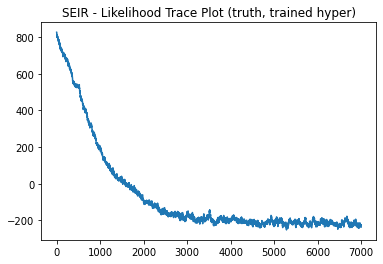

In [62]:
plt.plot(c[1000:])
plt.title('SEIR - Likelihood Trace Plot (truth, trained hyper)')
true_x_torch.shape

In [36]:
thetaFull = np.ndarray([64, 3])
thetaFull.fill(np.nan)
# interpolate: find the ydata of tvecFull given observations
for i in range(3):
    thetaFull[:, i] = np.interp(tvecFull, tvecObs, theta_true[:, i])
    
theta_true_torch = torch.tensor(thetaFull)

xFull = np.ndarray([64, 4])
xFull.fill(np.nan)
# interpolate: find the ydata of tvecFull given observations
for i in range(4):
    xFull[:, i] = np.interp(tvecFull, tvecObs, true_x[:, i])
    
true_x_torch = torch.tensor(xFull)
true_x_torch.shape

torch.Size([64, 4])

In [33]:
vectorize(pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch, time_constant_param_ls).shape

torch.Size([453])

In [29]:
def xthetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                         priorTemperature,
                         KinvthetaList):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    res2 = torch.zeros(1).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(
            (theta[:, thetaEachDim] - inferred_theta[thetaEachDim]) @ KinvthetaList[thetaEachDim] @ (
                    theta[:, thetaEachDim] - inferred_theta[thetaEachDim]))
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

    return torch.sum(res) + torch.sum(res_theta)

TVMAGI_xlatent_torch = torch.tensor(pointwise_xlatent_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
TVMAGI_theta_torch = torch.tensor(pointwise_theta_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
TVMAGI_sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
TVMAGI_optimizer = torch.optim.Adam([TVMAGI_xlatent_torch, TVMAGI_theta_torch, TVMAGI_sigma_torch] + time_constant_param_ls, lr=1e-4)
print(xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch, time_constant_param_ls, TVMAGI_sigma_torch,
                                                TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                priorTemperature, KinvthetaList))


0 12260692143.858969
100 10926098436.18485
200 9878702281.80343
300 8983637773.01537
400 8200280052.336187
500 7506361600.4215145
600 6887420777.724903
700 6332849519.91885
800 5834257350.79198
900 5384756814.068329
1000 4978566009.071925
1100 4610747125.004731
1200 4277028880.826708
1300 3973685721.773089
1400 3697453402.61012
1500 3445466321.996897
1600 3215207914.554912
1700 3004468853.969329
1800 2811310365.3214602
1900 2634031517.449211
2000 2471140581.9677033
2100 2321325305.1070204
2200 2183434245.506046
2300 2056449613.375045
2400 1939472936.0685303
2500 1831702842.6089406
2600 1732424421.1758783
2700 1640995818.5707464
2800 1556834894.2386212
2900 1479410814.7637622
3000 1408235925.6367135
3100 1342858431.1493537
3200 1282857740.690552
3300 1227836669.801558
3400 1177421611.5624914
3500 1131254044.6900723
3600 1088994611.5518606
3700 1050313244.3717713
3800 1014896598.4785483
3900 982438659.0595692
4000 952649824.2270768
4100 925246956.2895378
4200 899962671.7677897
4300 87654

KeyboardInterrupt: 

In [89]:
KthetaluList[0] @ KinvthetaluList[0]

tensor([[ 3.2232e+01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.9348e+01,  4.4458e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.1490e+01,  4.3973e+00,  1.4710e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-4.1865e-04, -4.0975e-04,  2.5757e-04,  ...,  6.7979e-01,
          0.0000e+00,  0.0000e+00],
        [-3.3837e-04, -3.3392e-04,  2.0906e-04,  ...,  6.1430e-01,
          2.2493e-01,  0.0000e+00],
        [-2.7338e-04, -2.7194e-04,  1.6960e-04,  ...,  2.2604e-01,
          4.1350e-01,  3.1025e-02]], dtype=torch.float64)

In [87]:
TVMAGI_theta_torch[:, 0]

tensor([0.4918, 0.6072, 0.7396, 0.8702, 0.9906, 1.1256, 1.2900, 1.4444, 1.5569,
        1.6805, 1.8723, 2.1343, 2.4450, 2.6906, 2.7519, 2.6982, 2.6673, 2.6647,
        2.6374, 2.5682, 2.4823, 2.4132, 2.3319, 2.1854, 1.9548, 1.6584, 1.3482,
        1.1035, 0.9717, 0.9076, 0.8584, 0.8354, 0.8585, 0.9188, 0.9992, 1.0755,
        1.1312, 1.2034, 1.3339, 1.5001, 1.6681, 1.8454, 2.0382, 2.2419, 2.4648,
        2.6692, 2.8087, 2.8318, 2.7530, 2.6595, 2.5900, 2.4963, 2.3334, 2.1376,
        1.9640, 1.8311, 1.7210, 1.5698, 1.3434, 1.1064, 0.9201, 0.7790, 0.6688,
        0.5833], dtype=torch.float64)

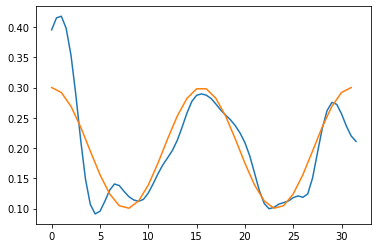

In [127]:
import matplotlib.pyplot as plt
tv_theta_ls = np.zeros(TVMAGI_theta_torch_LU.shape)
for thetaEachDim in range(TVMAGI_theta_torch_LU.shape[1]):
    TVMAGI_theta_torch = (KthetaluList[thetaEachDim] @ TVMAGI_theta_torch_LU.detach()[:, thetaEachDim]) + TV_theta_mean[thetaEachDim]
    theta_np = TVMAGI_theta_torch.numpy()
    tv_theta_ls[:, thetaEachDim] = theta_np.copy()
plt.plot(np.arange(0, 32, 0.5), tv_theta_ls[:, 2])
plt.plot(true_pd)

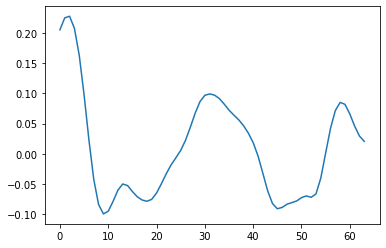

In [126]:
plt.plot(KthetaluList[2] @ TVMAGI_theta_torch_LU.detach()[:, 2])

In [125]:
inferred_theta

array([1.84631646, 0.10397016, 0.09924441, 0.19041272])

In [73]:
time_constant_param_ls

[tensor(0.0533, dtype=torch.float64, requires_grad=True)]

In [5]:
a = np.array([[1., 2,3,4]])
np.repeat(a, repeats=3, axis=0)

array([[1., 2., 3., 4.],
       [1., 2., 3., 4.],
       [1., 2., 3., 4.]])

# Package

In [2]:
import numpy as np
import torch
import scipy
import argparse
import sys
from arma import ode_system, solve_magi
from arma import matrix

# Derivatves of X according to the ODE structure
def fOde(theta, x):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[0] * np.exp(logI) / N  # (1)
    logEdt = theta[0] * np.exp(logS + logI - logE) / N - theta[1]  # (2)
    logIdt = np.exp(logE - logI) * theta[1] - theta[2]  # (3)
    logDdt = np.exp(logI - logD) * theta[3] * theta[2]  # (4)
    return np.stack([logSdt, logEdt, logIdt, logDdt], axis=1)


# Derivatives of X
def fOdeDx(theta, x):
    """
    returns derivation of x given theta
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    resultDx = np.zeros(shape=[np.shape(x)[0], np.shape(x)[1], np.shape(x)[1]])
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程关于第i个状态求导
    # (1) / dI
    resultDx[:, 2, 0] = -theta[0] * np.exp(logI) / N
    # (1) / dS, (1) /dE, (1) / dD = 0
    # (2) / dS
    resultDx[:, 0, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dE
    resultDx[:, 1, 1] = -theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dI
    resultDx[:, 2, 1] = theta[0] * np.exp(logS + logI - logE) / N
    # (2) / dD = 0
    # (3) / dS = 0
    # (3) / dE
    resultDx[:, 1, 2] = np.exp(logE - logI) * theta[1]
    # (3) / dI
    resultDx[:, 2, 2] = -np.exp(logE - logI) * theta[1]
    # (3) / dD = 0, (4) / dS, dE = 0
    # (4) / dI
    resultDx[:, 2, 3] = np.exp(logI - logD) * theta[3] * theta[2]
    # (4) / dD
    resultDx[:, 3, 3] = -np.exp(logI - logD) * theta[3] * theta[2]
    return resultDx


def fOdeDtheta(theta, x):
    """
    returns derivation of theta given x
    theta: list[4]
    x: array(n, 4)
    r: array(n, 4, 4)
    """
    global N
    resultDtheta = np.zeros(shape=[np.shape(x)[0], np.shape(theta)[0], np.shape(x)[1]])
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    # [:, i, j]: 第j个方程对theta_i求导
    # (1) / dRe
    resultDtheta[:, 0, 0] = -np.exp(logI) / N
    # (2) / d theta[0]
    resultDtheta[:, 0, 1] = np.exp(logS + logI - logE) / N
    # (2) / theta[1]
    resultDtheta[:, 1, 1] = -1.
    # (3) / dtheta[1]
    resultDtheta[:, 1, 2] = np.exp(logE - logI)
    # (3) / dtheta[2]
    resultDtheta[:, 2, 2] = -1.
    # (4) / theta[2]
    resultDtheta[:, 2, 3] = np.exp(logI - logD) * theta[3] 
    # (4) / theta[3]
    resultDtheta[:, 3, 3] = np.exp(logI - logD) * theta[2]
    return resultDtheta

def fOdeTorch(theta, x, constant_param_ls, KthetaluList=None):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    # LU decomposition
    if KthetasqrtList is not None:
        logS = x[:, 0]
        logE = x[:, 1]
        logI = x[:, 2]
        logD = x[:, 3]
        logSdt = (-KthetaluList[0] @ theta[:, 0]) * torch.exp(logI) / N  # (1)
        logEdt = (KthetaluList[0] @ theta[:, 0]) * torch.exp(logS + logI - logE) / N - (KthetaluList[1] @ theta[:, 1])  # (2)
        logIdt = torch.exp(logE - logI) * (KthetaluList[1] @ theta[:, 1]) - constant_param_ls[0]  # (3)
        logDdt = torch.exp(logI - logD) * (KthetaluList[2] @ theta[:, 2]) * constant_param_ls[0]  # (4)
    else:       
        logS = x[:, 0]
        logE = x[:, 1]
        logI = x[:, 2]
        logD = x[:, 3]
        logSdt = -theta[:, 0] * torch.exp(logI) / N  # (1)
        logEdt = theta[:, 0] * torch.exp(logS + logI - logE) / N - theta[:, 1]  # (2)
        logIdt = torch.exp(logE - logI) * theta[:, 1] - constant_param_ls[0]  # (3)
        logDdt = torch.exp(logI - logD) * theta[:, 2] * constant_param_ls[0]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature,
                                 obs_per_day):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)


def MaternKernel(d, phi_1, phi_2):
    """
    construct a kernel given time points and hyper parameters
    """
    a = torch.square(phi_1) * (
            1. + np.sqrt(5) * d / phi_2 + 5. * torch.square(d) / (3. * torch.square(phi_2))) * torch.exp(
        -np.sqrt(5) * d / phi_2)
    return a.double()


def kernelllik(phi_1, phi_2, sigma, y, d_matrix, phi1_lb=0.1, phi2_lb=10.):
    """
    optimize the kernel hyperparameters by maximizing marginal likelihood
    """
    phi_1_bounded = torch.clamp(phi_1, min=phi1_lb)
    phi_2_bounded = torch.clamp(phi_2, min=phi2_lb)
    K = MaternKernel(d_matrix, phi_1, phi_2)
    K += torch.square(sigma) * torch.eye(y.shape[0]).double()
    return -y.shape[0] * np.log(np.sqrt(2 * np.pi)) - 0.5 * y @ torch.inverse(K) @ y - 0.5 * torch.logdet(
        K) - 1e8 * torch.square(phi_1 - phi_1_bounded) - 1e6 * torch.square(phi_2 - phi_2_bounded)

def fOdeTorch(theta_LU, x, constant_param_ls, TV_theta_mean=None, KthetaluList=None):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    N = 100000
    # LU decomposition
    if KthetaluList is not None:
        logS = x[:, 0]
        logE = x[:, 1]
        logI = x[:, 2]
        logD = x[:, 3]
        logSdt = -(KthetaluList[0] @ theta_LU[:, 0] + TV_theta_mean[0]) * torch.exp(logI) / N  # (1)
        logEdt = (KthetaluList[0] @ theta_LU[:, 0] + TV_theta_mean[0]) * torch.exp(logS + logI - logE) / N - (KthetaluList[1] @ theta_LU[:, 1] + TV_theta_mean[1])  # (2)
        logIdt = torch.exp(logE - logI) * (KthetaluList[1] @ theta_LU[:, 1] + TV_theta_mean[1]) - constant_param_ls[0]  # (3)
        logDdt = torch.exp(logI - logD) * (KthetaluList[2] @ theta_LU[:, 2] + TV_theta_mean[2]) * constant_param_ls[0]  # (4)
    else:       
        logS = x[:, 0]
        logE = x[:, 1]
        logI = x[:, 2]
        logD = x[:, 3]
        logSdt = -theta_LU[:, 0] * torch.exp(logI) / N  # (1)
        logEdt = theta_LU[:, 0] * torch.exp(logS + logI - logE) / N - theta_LU[:, 1]  # (2)
        logIdt = torch.exp(logE - logI) * theta_LU[:, 1] - constant_param_ls[0]  # (3)
        logDdt = torch.exp(logI - logD) * theta_LU[:, 2] * constant_param_ls[0]  # (4)
    return torch.stack([logSdt, logEdt, logIdt, logDdt], axis=1)

def xthetasigmallikTorch(xlatent, theta_LU, time_constant_param_ls, sigma, inferred_theta, ydata, CovAllDimensionsPyList, fOdeTorch,
                         priorTemperature, KthetaluList):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta_LU.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta_LU, xlatent, time_constant_param_ls, inferred_theta, KthetaluList)
    res = torch.zeros([pdimension, 3]).double()
    res_theta = torch.zeros(thetadimension).double()
    res2 = torch.zeros(1).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.0001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    for thetaEachDim in range(thetadimension):
        res_theta[thetaEachDim] = -0.5 * torch.sum(torch.square(theta_LU[:, thetaEachDim]-inferred_theta[thetaEachDim]))
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]

    return torch.sum(res) + torch.sum(res_theta)


def TVMAGI_solver(obs_per_day=1,
                  discretization=2,
                  theta_lowerbound=np.array([0., 0., 0., 0.]),
                  theta_upperbound=np.array([np.inf, 1., 1., 1.]),
                  MAGI_niter=15001,
                  param_names = ['re', 've', 'vi', 'pd'],
                  is_time_varying=[True, True, False, True],
                  pointwise_niter=150000,
                  kernel_niter=60000,
                  TVMAGI_niter=100000,
                  phi1_lb_ls=np.array([0.1, 0.1, 0.1]),
                  phi2_lb_ls=np.array([0.1, 0.1, 0.1]),
                  use_trajectory='inferred',
                  learning_rate=np.array([1e-5, 1e-3, 1e-4])):
    
    nobs, p_dim = yobs.shape[0], yobs.shape[1]
    days = nobs / obs_per_day
    n_points = nobs * discretization
    theta_dim = theta_lowerbound.shape[0]
    d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
    for i in range(n_points):
        for j in range(n_points):
            if i > j:
                d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
            else:
                d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
    Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                             thetaLowerBound=theta_lowerbound,
                             thetaUpperBound=theta_upperbound)
    tvecObs = np.arange(0, days, 1. / obs_per_day)
    tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
    yFull = np.ndarray([n_points, p_dim])
    yFull.fill(np.nan)
    yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
    xInitExogenous = np.zeros_like(yFull)
    # interpolate: find the ydata of tvecFull given observations
    for i in range(p_dim):
        xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
    # First stage: use MAGI package to optimize theta as constant
    result = solve_magi(
        yFull,
        Ode_system,
        tvecFull,
        sigmaExogenous=np.array([]),
        phiExogenous=np.array([[]]),
        xInitExogenous=xInitExogenous,
        thetaInitExogenous=np.array([]),
        muExogenous=np.array([[]]),
        dotmuExogenous=np.array([[]]),
        priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
        priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
        priorTemperatureObs=1.0,
        kernel="generalMatern",
        nstepsHmc=100,
        burninRatioHmc=0.5,
        niterHmc=MAGI_niter,
        stepSizeFactorHmc=0.01,
        nEpoch=1,
        bandSize=40,
        useFrequencyBasedPrior=True,
        useBand=False,
        useMean=False,
        useScalerSigma=False,
        useFixedSigma=False,
        verbose=True)
    samplesCpp = result['samplesCpp']
    llikId = 0
    xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
    # dimension of theta
    thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
    sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
    burnin = int(MAGI_niter * 0.5)
    xsampled = samplesCpp[xId, (burnin + 1):]
    xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
    CovAllDimensionsPyList = []
    thetaSampled = samplesCpp[thetaId, (burnin + 1):]
    inferred_theta = np.mean(thetaSampled, axis=-1)
    sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
    inferred_sigma = np.mean(sigmaSampled, axis=-1)
    inferred_trajectory = np.mean(xsampled, axis=-1)
    for each_gpcov in result['result_solved'].covAllDimensions:
            each_pycov = dict(
                Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
                Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
                mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
            )
            CovAllDimensionsPyList.append(each_pycov)
            
    # Second stage, pointwise estimation of theta
    TV_theta_mean = np.zeros(int(sum(is_time_varying)))
    tv_index = 0
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == True:
            TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
            tv_index += 1

    if use_trajectory == 'observation':
        pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
    elif use_trajectory == 'inferred':
        pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
    else:
        raise ValueError
    tmp1 = np.array([TV_theta_mean])
    initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
    pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
    sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
    time_constant_param_ls = []
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == 0:
            param_name = param_names[thetaEachDim]
            locals()[param_name] = torch.tensor(inferred_theta[thetaEachDim], requires_grad=True, dtype=torch.double)
            time_constant_param_ls.append(eval(param_name))

    ydata = torch.from_numpy(yFull).double()
    priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
    pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=learning_rate[0])  # , weight_decay = 1.0
    for epoch in range(pointwise_niter):
        pointwise_optimizer.zero_grad()
        # compute loss function
        llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                            TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                            priorTemperature, obs_per_day)
        loss = -llik
        if epoch % 100 == 0:
            print(epoch, loss.item())
        # compute gradient and update parameters
        #     if loss < -345. and epoch > 50000:
        #         break
        loss.backward()
        pointwise_optimizer.step()
        
    pointwise_theta = pointwise_theta_torch.detach().numpy()
    hyperparamList = []
    # optimize the hyperparameters of kernels
    for thetaEachDimension in range(pointwise_theta.shape[1]):
        phi_1 = torch.tensor(1., requires_grad=True, dtype=torch.double)
        phi_2 = torch.tensor(20.0, requires_grad=True, dtype=torch.double)
        sigma = torch.tensor(0.001, requires_grad=True, dtype=torch.double)
        kernel_optimizer = torch.optim.Adam([phi_1, phi_2, sigma], lr=learning_rate[1])
        for epoch in range(kernel_niter):
            kernel_optimizer.zero_grad()
            loss = -kernelllik(phi_1, 
                               phi_2, 
                               sigma, 
                               pointwise_theta_torch[:, thetaEachDimension] - torch.mean(pointwise_theta_torch[:, thetaEachDimension]), 
                               d_matrix, 
                               phi1_lb_ls[thetaEachDimension], 
                               phi2_lb_ls[thetaEachDimension])
            loss.backward()
            kernel_optimizer.step()
            if epoch % 100 == 0:
                print(epoch, loss.item())
        print(phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item())
        hyperparamList.append([phi_1.detach().item(), phi_2.detach().item(), sigma.detach().item()])

    KthetaList = []
    KthetaluList = []
    KinvthetaList = []
    KinvthetaluList = []
    for thetaEachDimension in range(pointwise_theta.shape[1]):
        ker = MaternKernel(d_matrix, torch.tensor(hyperparamList[thetaEachDimension][0]), torch.tensor(hyperparamList[thetaEachDimension][1]))
        KthetaList.append(ker)
        L_mat = torch.cholesky(ker)
        KthetaluList.append(L_mat)
        L_inv = torch.inverse(L_mat)
        KinvthetaluList.append(L_inv)
        
    TVMAGI_xlatent_torch = torch.tensor(pointwise_xlatent_torch.detach().numpy(), requires_grad=True, dtype=torch.double)
    TVMAGI_theta_torch = torch.tensor(pointwise_theta_torch.detach().numpy(), dtype=torch.double)
    TVMAGI_theta_torch_LU = torch.zeros(TVMAGI_theta_torch.shape).double()
    for thetaEachDim in range(TVMAGI_theta_torch.shape[1]):
        TVMAGI_theta_torch_LU[:, thetaEachDim] = KinvthetaluList[thetaEachDim] @ (TVMAGI_theta_torch[:, thetaEachDim] - inferred_theta[thetaEachDim])
    TVMAGI_theta_torch_LU.requires_grad = True
    TVMAGI_sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
    TVMAGI_optimizer = torch.optim.Adam([TVMAGI_xlatent_torch, TVMAGI_theta_torch_LU, TVMAGI_sigma_torch] + time_constant_param_ls, lr=learning_rate[2])
    for epoch in range(TVMAGI_niter):
        TVMAGI_optimizer.zero_grad()
        # compute loss function
        llik = xthetasigmallikTorch(TVMAGI_xlatent_torch, TVMAGI_theta_torch_LU, time_constant_param_ls, TVMAGI_sigma_torch,
                                                    TV_theta_mean, ydata, CovAllDimensionsPyList, fOdeTorch,
                                                    priorTemperature, KthetaluList)
        loss = -llik
        if epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        TVMAGI_optimizer.step()
    
    tv_theta_ls = np.zeros(TVMAGI_theta_torch_LU.shape)
    for thetaEachDim in range(TVMAGI_theta_torch_LU.shape[1]):
        TVMAGI_theta_torch = (KthetaluList[thetaEachDim] @ TVMAGI_theta_torch_LU.detach()[:, thetaEachDim]) + TV_theta_mean[thetaEachDim]
        theta_np = TVMAGI_theta_torch.numpy()
        tv_theta_ls[:, thetaEachDim] = theta_np.copy()
    
#     param_dict = {}
#     constant_index, tv_index = 0, 0
#     for thetaEachDim in range(theta_dim):
#         if is_time_varying[thetaEachDim] == True:
#             param_dict[param_names[thetaEachDim]] = tv_theta_ls[:, tv_index].copy()
#             tv_index += 1
#         else:
#             param_dict[param_names[thetaEachDim]] = time_constant_param_ls[constant_index].item()
#             constant_index += 1
    return tv_theta_ls, time_constant_param_ls

In [3]:
a, b = TVMAGI_solver(obs_per_day=1,
                  discretization=2,
                  theta_lowerbound=np.array([0., 0., 0., 0.]),
                  theta_upperbound=np.array([np.inf, 1., 1., 1.]),
                  MAGI_niter=15001,
                  param_names = ['re', 've', 'vi', 'pd'],
                  is_time_varying=[True, True, False, True],
                  pointwise_niter=150000,
                  kernel_niter=60000,
                  TVMAGI_niter=100000,
                  phi1_lb_ls=np.array([0.1, 0.1, 0.1]),
                  phi2_lb_ls=np.array([0.1, 0.1, 0.1]),
                  use_trajectory='inferred',
                  learning_rate=np.array([1e-5, 1e-3, 1e-3]))

0 -95.89162522619533


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


100 -128.4379605213447
200 -131.1606111513363
300 -131.44630763245578
400 -131.6698000103461
500 -131.88498785792623
600 -132.09587448112836
700 -132.3038634786692
800 -132.5099801621835
900 -132.7151300225027
1000 -132.92012587801554
1100 -133.12568504219172
1200 -133.33242815116444
1300 -133.54090132984817
1400 -133.75157548184956
1500 -133.9648586280438
1600 -134.18110734369898
1700 -134.40064032135822
1800 -134.62374559523442
1900 -134.85067499384076
2000 -135.08165025267402
2100 -135.31687684553648
2200 -135.55653025346965
2300 -135.80075867354628
2400 -136.0496977440463
2500 -136.3034581236237
2600 -136.5621285149665
2700 -136.82578777005534
2800 -137.0944860148776
2900 -137.36825947169316
3000 -137.64714333146105
3100 -137.9311486453879
3200 -138.22026456659103
3300 -138.51448236050504
3400 -138.8137707090167
3500 -139.1180753856251
3600 -139.42735673405855
3700 -139.74154800913198
3800 -140.06055141986758
3900 -140.3842824885361
4000 -140.71263526343967
4100 -141.04549300908138

32500 -271.0960090446129
32600 -271.67172985509296
32700 -272.2455559718953
32800 -272.81739401346454
32900 -273.3871680471055
33000 -273.95480234276295
33100 -274.52020265048293
33200 -275.0832993841864
33300 -275.6440134009428
33400 -276.2022374307511
33500 -276.7578848046925
33600 -277.3108771650817
33700 -277.86109280195296
33800 -278.40845481619283
33900 -278.9528425334989
34000 -279.4941532784314
34100 -280.0322714409316
34200 -280.5670851775056
34300 -281.0984760723838
34400 -281.62632983187075
34500 -282.15051940213914
34600 -282.67092317206055
34700 -283.18740235775704
34800 -283.6998625751527
34900 -284.2081140200575
35000 -284.7121043100214
35100 -285.21166028455735
35200 -285.70661815040245
35300 -286.196869568978
35400 -286.682236381119
35500 -287.1626409292244
35600 -287.6378856850565
35700 -288.10783650405835
35800 -288.57234154415494
35900 -289.0312727177569
36000 -289.4844928337625
36100 -289.93186096055166
36200 -290.3732590499884
36300 -290.8085677806668
36400 -291.2

64800 -354.3899012319774
64900 -354.6228115428192
65000 -354.85604769664064
65100 -355.08959152967907
65200 -355.3234611104308
65300 -355.5576395106445
65400 -355.7921088884793
65500 -356.0269182417212
65600 -356.26201627352054
65700 -356.4974111951893
65800 -356.7331174419526
65900 -356.96910959535444
66000 -357.205349272557
66100 -357.44198641040873
66200 -357.67885082918326
66300 -357.91600220416103
66400 -358.1534377873004
66500 -358.3911483551918
66600 -358.6291200627651
66700 -358.8673614261411
66800 -359.1059076637168
66900 -359.344695323336
67000 -359.58374013302745
67100 -359.8230099175423
67200 -360.0625707042138
67300 -360.30239390794765
67400 -360.5424460876708
67500 -360.7827138197114
67600 -361.0232491227692
67700 -361.26399538582933
67800 -361.50498837715963
67900 -361.7461921041352
68000 -361.9876149087691
68100 -362.22924665560106
68200 -362.47109805406546
68300 -362.71315202554683
68400 -362.955405439986
68500 -363.1978547757584
68600 -363.4404914400162
68700 -363.683

97100 -419.3840516170302
97200 -419.4702131140706
97300 -419.5554621107518
97400 -419.6397269916888
97500 -419.72304718114157
97600 -419.8054115077949
97700 -419.88682020560236
97800 -419.9672333839239
97900 -420.04677780142174
98000 -420.12531996978447
98100 -420.2029091436001
98200 -420.27956924351895
98300 -420.35526751657085
98400 -420.4300069943006
98500 -420.5038093065815
98600 -420.5766594779908
98700 -420.6485860593881
98800 -420.7195343672778
98900 -420.7896111207014
99000 -420.858717367685
99100 -420.92692100328736
99200 -420.9941985993349
99300 -421.0605618731021
99400 -421.12601282989914
99500 -421.19051527903946
99600 -421.25419613652434
99700 -421.31690338192817
99800 -421.3788699271883
99900 -421.43987945395713
100000 -421.50002453757264
100100 -421.55931078125684
100200 -421.6177400100804
100300 -421.6753294996555
100400 -421.73207835891674
100500 -421.78800030968466
100600 -421.8430907157333
100700 -421.89738535737837
100800 -421.95086682209535
100900 -422.003545315059

128400 -425.41696366809504
128500 -425.4169567239556
128600 -425.4169645048602
128700 -425.41693972013877
128800 -425.4169259041561
128900 -425.4169584966304
129000 -425.4169590405152
129100 -425.41696278752397
129200 -425.4169646763156
129300 -425.4169615080502
129400 -425.41696296406303
129500 -425.4169648932184
129600 -425.41695599163813
129700 -425.4169487994865
129800 -425.41695666722916
129900 -425.4169641014537
130000 -425.41693554412495
130100 -425.4169620905779
130200 -425.4169610121028
130300 -425.41696460138655
130400 -425.4169537903997
130500 -425.416963968499
130600 -425.41696269521304
130700 -425.4169578343271
130800 -425.4169562297288
130900 -425.41696357166904
131000 -425.4169638868116
131100 -425.4169639468684
131200 -425.4169626793155
131300 -425.4169631619104
131400 -425.4169606219035
131500 -425.41695505576035
131600 -425.41696425913267
131700 -425.4169608776143
131800 -425.4169628145277
131900 -425.41695498189927
132000 -425.4169602765952
132100 -425.4169517629895


10500 -34.41066451796897
10600 -34.619873529524014
10700 -34.82185406688973
10800 -35.016899316527514
10900 -35.205293854967536
11000 -35.38731461009192
11100 -35.56323164729919
11200 -35.733308804661235
11300 -35.897804207942315
11400 -36.056970695481624
11500 -36.211056184913275
11600 -36.36030400861078
11700 -36.50495324113544
11800 -36.64523903808961
11900 -36.78139300163676
12000 -36.91364358469568
12100 -37.042216544161164
12200 -37.16733545198407
12300 -37.28922227375541
12400 -37.408098025574475
12500 -37.52418351997197
12600 -37.63770021771501
12700 -37.748871201774875
12800 -37.857922298535925
12900 -37.96508337265459
13000 -38.070589835569024
13100 -38.1746844098499
13200 -38.277619212591674
13300 -38.37965823235291
13400 -38.48108029910699
13500 -38.58218267770269
13600 -38.68328545366347
13700 -38.784736940184956
13800 -38.88692040675326
13900 -38.990262542203155
14000 -39.09524421244811
14100 -39.20241428806
14200 -39.31240762526281
14300 -39.42596873860005
14400 -39.5439

43400 -97.28689595704941
43500 -97.28689592886927
43600 -97.28689595695178
43700 -97.28644300536789
43800 -97.28689585935528
43900 -97.28689556236148
44000 -97.28689595702104
44100 -97.28689595660268
44200 -97.28688112351216
44300 -97.28689594631946
44400 -97.28689595690676
44500 -97.28689594984318
44600 -97.28585669357415
44700 -97.2868957146984
44800 -97.28689595687065
44900 -97.28689593760541
45000 -97.28689595544793
45100 -97.28689438725931
45200 -97.28689595680247
45300 -97.28689595697607
45400 -97.2868959446458
45500 -97.286844914077
45600 -97.28689595583262
45700 -97.2868958977559
45800 -97.28689595709129
45900 -97.28684658479693
46000 -97.28689593894634
46100 -97.28689595697689
46200 -97.2868959545491
46300 -97.28689029503127
46400 -97.28689572839885
46500 -97.28689595576073
46600 -97.28689595678075
46700 -97.28689595636021
46800 -97.28686233711875
46900 -97.28689592958469
47000 -97.28689595705052
47100 -97.28689587518512
47200 -97.28541425673853
47300 -97.2868957745051
47400 -

16100 -254.86801297682084
16200 -255.2288576165493
16300 -255.53236561162495
16400 -255.9057413572622
16500 -256.26208279677553
16600 -256.5755304715989
16700 -256.9840952731633
16800 -257.3467083727114
16900 -257.7305852346608
17000 -258.1154153923171
17100 -258.48096003838043
17200 -258.90212435198634
17300 -259.24307396979657
17400 -259.6835649289625
17500 -258.8149803707714
17600 -259.315510997858
17700 -259.57316229457047
17800 -259.81998598473075
17900 -259.2692131561083
18000 -259.8367951950462
18100 -259.8519586213159
18200 -259.1654271980657
18300 -259.75872087880714
18400 -259.6860910760911
18500 -259.6254156904719
18600 -259.54909175833217
18700 -259.532156426488
18800 -259.7181692188613
18900 -259.7708962975704
19000 -259.5989111040001
19100 -259.2941530995269
19200 -259.86575343956275
19300 -259.896298684012
19400 -259.8179212266891
19500 -259.48035101978735
19600 -259.43716213140783
19700 -259.5686916791638
19800 -259.84050635165124
19900 -259.29370172555866
20000 -259.82

48500 -259.7522139887587
48600 -259.6526241647708
48700 -259.41483700284425
48800 -259.7846525787078
48900 -259.63253231622195
49000 -259.65880078585826
49100 -259.7798275158503
49200 -259.8628469045833
49300 -259.88435608362676
49400 -258.90560518616394
49500 -259.6083606074202
49600 -259.89147079086604
49700 -259.39566619245375
49800 -259.7772181274237
49900 -259.9159426879822
50000 -259.64102241632247
50100 -259.86543963128184
50200 -259.304574075206
50300 -259.9000294495527
50400 -259.47798787271336
50500 -259.8960337564954
50600 -259.86016863010775
50700 -259.59349619132286
50800 -259.6646035974674
50900 -259.7306820978191
51000 -259.8652797098146
51100 -259.680037485149
51200 -259.5820429534909
51300 -259.28006568007277
51400 -259.84004146679655
51500 -259.50852235182197
51600 -259.849579911213
51700 -259.28160495046313
51800 -259.8387378929717
51900 -259.66040639036305
52000 -259.8645838154901
52100 -259.29558321893023
52200 -259.3965392937632
52300 -259.84602250783155
52400 -25

21300 -46.79984947519023
21400 -46.82081046199259
21500 -46.841773072245104
21600 -46.862734768899344
21700 -46.88369292769616
21800 -46.90464483320994
21900 -46.92558767492639
22000 -46.94651854334582
22100 -46.96743442610796
22200 -46.98833220412371
22300 -47.009208647714544
22400 -47.03006041275309
22500 -47.05088403680209
22600 -47.07167593524761
22700 -47.09243239743057
22800 -47.11314958277231
22900 -47.13382351689823
23000 -47.15445008776308
23100 -47.175025041781794
23200 -47.19554397997085
23300 -47.21600235410929
23400 -47.236395462928556
23500 -47.256718448339996
23600 -47.27696629171595
23700 -47.29713381023609
23800 -47.317215653319764
23900 -47.33720629916175
24000 -47.357100051394184
24100 -47.37689103590107
24200 -47.396573197814035
24300 -47.41614029872093
24400 -47.435585914125625
24500 -47.454903431198545
24600 -47.47408604686473
24700 -47.493126766281335
24800 -47.51201840176108
24900 -47.530753572207715
25000 -47.549324703133465
25100 -47.567724027339324
25200 -47.

54100 -94.25445994076358
54200 -94.25445959738853
54300 -94.25445997889642
54400 -94.25445997893604
54500 -94.25443045847442
54600 -94.25445997667822
54700 -94.25445997893578
54800 -94.2544597700282
54900 -94.25356435064359
55000 -94.2544599665527
55100 -94.25445996910487
55200 -94.25445997893702
55300 -94.25445875584137
55400 -94.25444419475373
55500 -94.25445997790568
55600 -94.2544598552094
55700 -94.25445997893466
55800 -94.25445995768035
55900 -94.25445876880687
56000 -94.25445997888892
56100 -94.2544599789357
56200 -94.25445068998762
56300 -94.25442258466938
56400 -94.2544599761824
56500 -94.25445997892461
56600 -94.25445995657611
56700 -94.25445997796852
56800 -94.25445995904272
56900 -94.25445221775604
57000 -94.25445997885359
57100 -94.25445997893625
57200 -94.2544579878211
57300 -94.2544446613143
57400 -94.25445997858714
57500 -94.25445997859333
57600 -94.25445997785421
57700 -94.25445997893569
57800 -94.25438291725725
57900 -94.254458829385
58000 -94.2544599789066
58100 -94.

26800 -297.7714503648322
26900 -297.8321606065098
27000 -297.8327680933081
27100 -297.7769232561839
27200 -297.8131466960898
27300 -297.84000050250694
27400 -297.8149303701167
27500 -297.83959921858326
27600 -297.82064077069697
27700 -297.8277700016796
27800 -297.8232688623764
27900 -297.8191082053667
28000 -297.77977442952266
28100 -297.82673910591654
28200 -297.8313747690471
28300 -297.7894980605238
28400 -297.58524968269575
28500 -297.7735679816865
28600 -297.4248201386345
28700 -297.83882001580355
28800 -297.8413289182033
28900 -297.82507723398834
29000 -297.81717226900787
29100 -297.8103972965321
29200 -297.8373522276886
29300 -297.8351648502313
29400 -297.8304219379603
29500 -297.84130960897943
29600 -297.46819049267987
29700 -297.8149976701789
29800 -297.8186677818794
29900 -297.65481604937935
30000 -297.8148956065049
30100 -297.8270633731565
30200 -297.7710180755018
30300 -297.81618275734854
30400 -297.8316942723129
30500 -297.82958472544556
30600 -297.8097343771634
30700 -297.

59200 -297.76427679005945
59300 -297.83494750076
59400 -297.8210607284742
59500 -297.84786437359287
59600 -297.81690880015174
59700 -297.8201964235829
59800 -297.8341925497012
59900 -297.8153395182594
60000 -297.8014322917672
60100 -297.7846058107327
60200 -297.8015468112904
60300 -297.82525224162174
60400 -297.839072599686
60500 -297.8358378854466
60600 -297.8224939800393
60700 -297.6941193607502
60800 -297.8300802617573
60900 -297.8340173088617
61000 -297.77986242907775
61100 -297.82754374812095
61200 -297.81387445947985
61300 -297.81790788590763
61400 -297.8373135629317
61500 -297.83836506183343
61600 -297.8323844469885
61700 -297.7250827982167
61800 -297.7993964745341
61900 -297.74295109763113
62000 -297.83428984035817
62100 -297.81717226098084
62200 -297.62743424232536
62300 -297.80729947786665
62400 -297.83740100047004
62500 -297.82655210251755
62600 -297.7603012550016
62700 -297.83044947603923
62800 -297.8328741941558
62900 -297.75774265523336
63000 -297.80550490312703
63100 -29

91500 -297.8077985280172
91600 -297.76339047646024
91700 -297.46609045968535
91800 -297.81006424250194
91900 -297.8052240330047
92000 -297.80396953473354
92100 -297.77391856423003
92200 -297.7955202386521
92300 -297.8344495087305
92400 -297.5760881415984
92500 -297.7911894572426
92600 -297.56304861009795
92700 -297.7902921335567
92800 -297.8168632252575
92900 -297.81483188243726
93000 -297.7557979767304
93100 -297.8330283031078
93200 -297.79498045273715
93300 -297.821431945659
93400 -297.80959370299536
93500 -297.8129518324389
93600 -297.8371682459341
93700 -297.8271601061796
93800 -297.4618201144185
93900 -297.79427282321103
94000 -297.7863089355633
94100 -297.8221488291666
94200 -297.83313298027974
94300 -297.7166516482387
94400 -297.80993569192026
94500 -297.79941978562306
94600 -297.835251707402
94700 -297.79956245869124
94800 -297.73824103970276
94900 -297.75587543205893
95000 -297.6688268185679
95100 -297.7684953139152
95200 -297.82361206624023
95300 -297.83795049835146
95400 -29

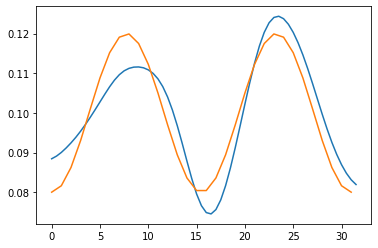

In [13]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0, 32, 0.5), a[:, 1])
plt.plot(true_ve)

In [5]:
b

[tensor(0.0980, dtype=torch.float64, requires_grad=True)]